In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import copy

from scipy import optimize
from sklearn import decomposition, cluster

import umap
import umap.plot

In [2]:
class ArgumentParser():
    def __init__(self, **kwargs):
        for key, value in kwargs:
            setattr(self, key[2:], value)
            
    def add_argument(self, key, value):
        setattr(self, key[2:], value)
        

In [51]:
args = ArgumentParser()

args.add_argument('--n_dims', 20)
args.add_argument('--data_dir', "../../data/HSI/Liver_map_150z25_60s_1TCPOBOP.npy")
args.add_argument('--output_dir', '../../PCA_output')
args.add_argument('--n_clusters', 3)


X = np.load(args.data_dir, 'r')
Shape = X.shape

X = copy.copy(X.reshape(-1, X.shape[-1]))

In [52]:
###################### PCA ################################

X /= np.max(X)

pca = decomposition.PCA(n_components=args.n_dims)
pca.fit(X)

X_pca = pca.transform(X)




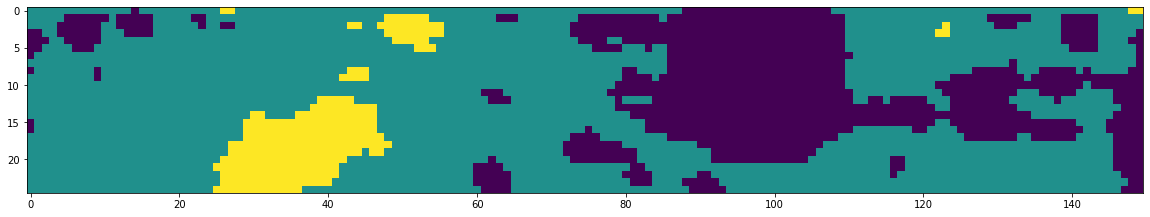

In [53]:

###################### clustering ################################


clusters = cluster.KMeans(n_clusters=args.n_clusters).fit(X_pca)
clusters = clusters.labels_
one_hot = np.zeros((X.shape[0], args.n_clusters), dtype=bool)

one_hot[range(X.shape[0]), clusters] = 1

plt.figure(figsize = (20,4))
plt.imshow(clusters.reshape(Shape[:2]).T)

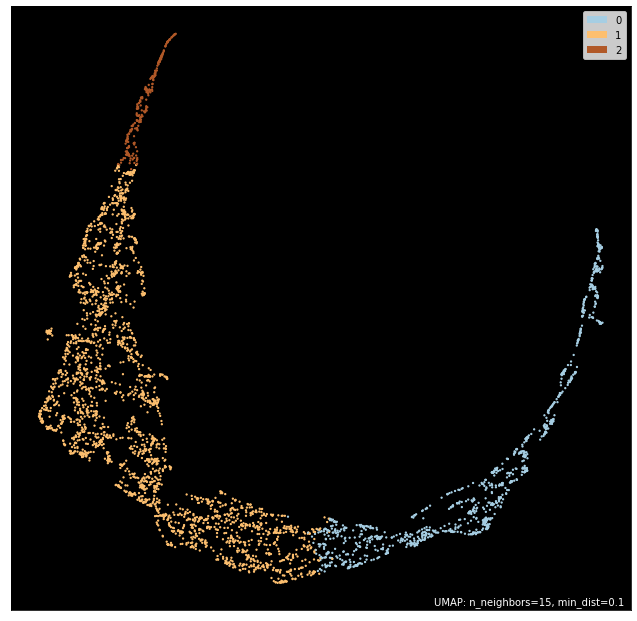

In [60]:
###################### UMAP ################################

mapper = umap.UMAP(n_neighbors=15, n_components=2, metric='euclidean', min_dist=0.1).fit(X)
umap.plot.points(mapper, labels=clusters, color_key_cmap='Paired', background='black')
umap.plot.plt.show()


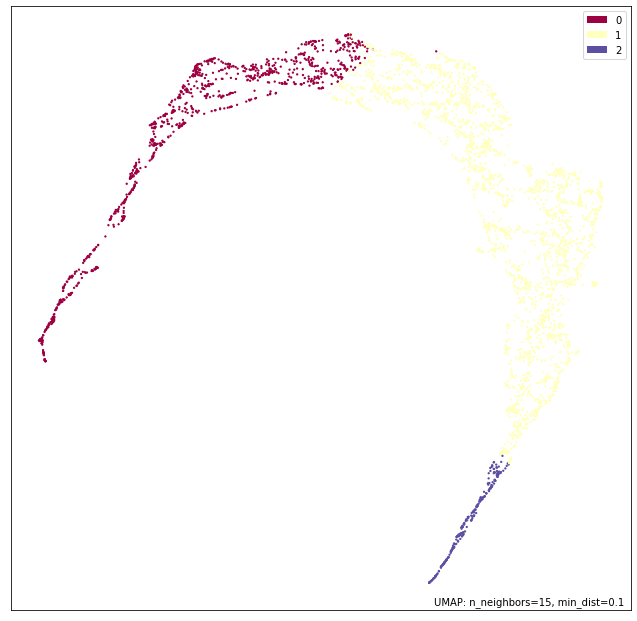

In [55]:
###################### UMAP on pca ################################
mapper = umap.UMAP(n_neighbors=15, n_components=2, metric='euclidean', min_dist=0.1).fit(X_pca)
umap.plot.points(mapper, labels=clusters, color_key_cmap='Paired', background='black')
umap.plot.plt.show()

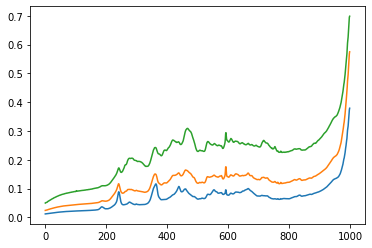

In [56]:
###################### reference spectra ################################
reference_spectra = np.array([X[one_hot[:,i],:].mean(axis=0) for i in range(args.n_clusters)])
for ref in reference_spectra:
    plt.plot(ref)
plt.show()

In [57]:
RCA_vector, error = list(zip(*[optimize.nnls(reference_spectra.T, X[i,:]) for i in range(X.shape[0])]))
RCA_vector = np.array(RCA_vector)
error = np.array(error)

In [63]:
error.mean(), error.std()

(0.15823573568548466, 0.09155885898749808)

TypeError: Invalid shape (3, 25, 150) for image data

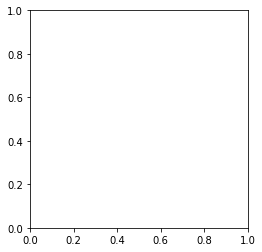

In [61]:
plt.figure(figsize = (20,4))
plt.imshow(RCA_vector.reshape((*Shape[:2], args.n_clusters)))